# Functions to transform the output of the model (masks) into .roi files

In [15]:
import cv2 

def contour_from_mask(mask):
    # cv2.findContours only works on binary image, hence the following two lines
    imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
    _, thresh = cv2.threshold(imgray, 100, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours[0] #there should be only one contour

def roi_from_contour(name, cnt):
    x = cnt[:,0,0]
    y = cnt[:,0,1]
    dict_data = {
        'type':'freehand',
        'x': list(x),
        'y': list(y),
        'n':len(x),
        'width':0,
        'name':name,
        'position':0
    }
    roi = { name : dict_data }
    return(roi)

# TO DO
# def create_roi_file(roi):
# see file format https://imagej.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
    

In [4]:
import skimage.io
mask = skimage.io.imread(IMG_FOLDER+'/Masks/R22 VEGF 2_15.0xC1_0075-1108.jpg')

In [16]:
roi1 = roi_from_contour('R22 VEGF 2_15.0xC1_0075-1108',contour_from_mask(mask))

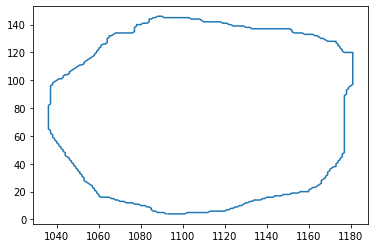

In [20]:
import matplotlib.pyplot as plt
for name in roi1:
    plt.plot(roi1[name]['x'],roi1[name]['y'])